# Problem 1 - Direction-of-Arrival (DOA) Estimation

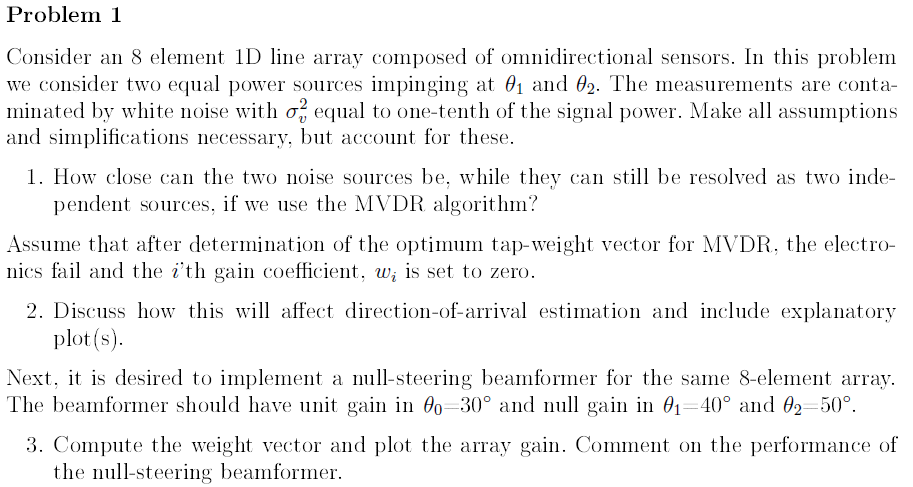

## 1)

\begin {equation}
\bold{x}[n]=
\begin{bmatrix}
    a[n]e^{j\phi_0} \\
    a[n]e^{j(\phi_0+\pi\sin(\theta))}\\
    \vdots \\
    a[n]e^{j(\phi_0+(M-1)\pi\sin(\theta))}
\end{bmatrix}
\end{equation}

\begin {equation}
\bold{s}(\theta)=
\begin{bmatrix}
    1 \\
    e^{j\pi\sin(\theta)} \\
    \vdots \\
    e^{j(M-1)\pi\sin(\theta)}
\end{bmatrix}
\end{equation}

\begin{equation}
    \bold(x)[n] = a_1[n]\bold{s}(\theta_1) + a_2\bold{s}(\theta_2) + \bold{v}[n]
\end{equation}

\begin{equation}
    \hat{R}=\frac{\sum_{n=0}^{N-1}\bold{x}[n]\bold{x}^H[n]}{N}
\end{equation}

\begin{equation}
    \hat{R}=\frac{XX^H}{N}
\end{equation}

\begin{equation}
    S(\theta) =\bold{w}_{opt}^H\hat{R}\bold{w}_{opt}
\end{equation}

\begin{equation}
    \bold{w}_opt = \frac{\hat{R}^{-1}\bold{s}(\theta)}{\bold{s}^H(\theta)\hat{R}^{-1}\bold{s}(\theta)}
\end{equation}

c:\repositories\AdvancedSignalProcessing\.venv\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\repositories\AdvancedSignalProcessing\.venv\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


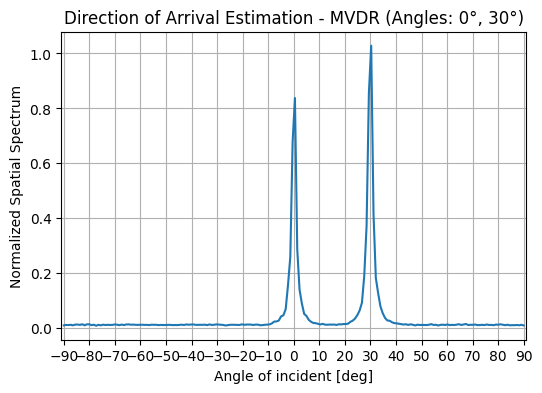

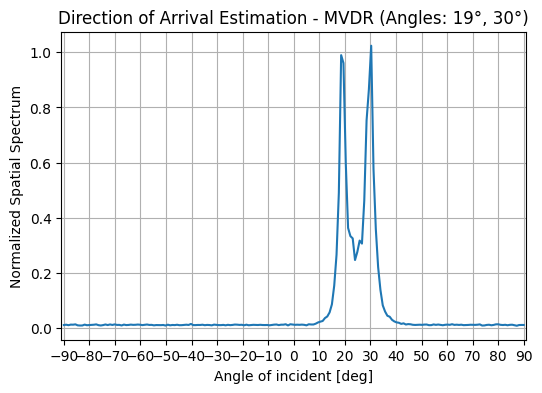

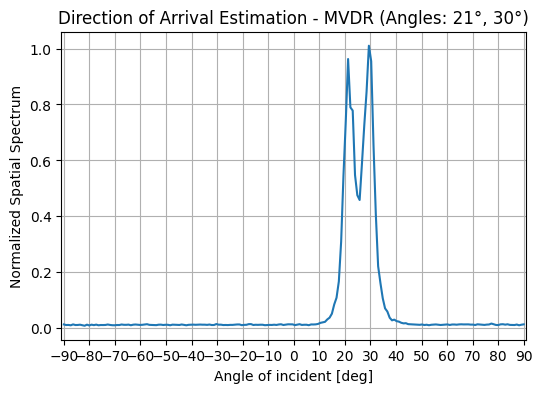

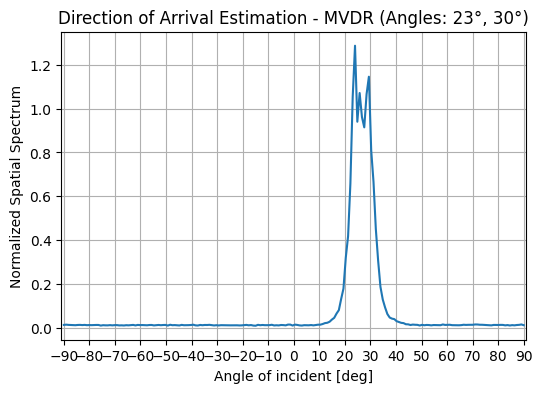

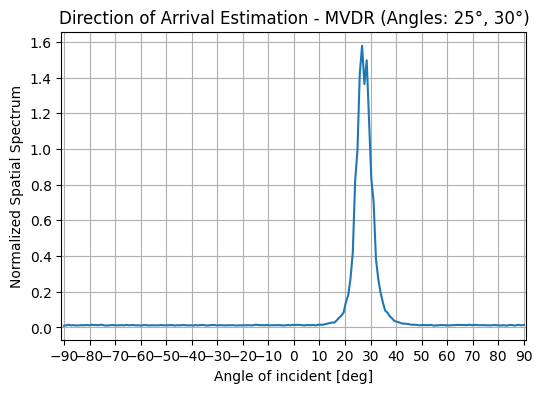

SNR = 10.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

def MVDR_DOA(N, M, P, sig2, angle_pairs, observation_angles, savefig=False, w_fail=False):
    """
    MVDR beamformer for DOA estimation and spectrum plotting for multiple angle pairs.

    Parameters:
    - N: int
        Number of time samples.
    - M: int
        Number of array elements.
    - P: list of float
        Power of the two incoming signals [P1, P2].
    - sig2: float
        Variance of the additive noise.
    - angle_pairs: list of tuple
        List of pairs of incident angles for the two incoming signals [(theta1, theta2), ...].
    - observation_angles: ndarray
        Array of observation angles (degrees).

    Returns:
    - results: dict
        Dictionary containing the spatial spectrum for each angle pair.
    """
    rand_index = np.random.randint(0,M)
    printed = False
    def MVDR(N, M, theta_obs, theta1, theta2, P1, P2, sig2):
        nonlocal printed
        # Steering vectors for the two incident signals
        s1 = np.array([np.exp(1j * np.pi * np.sin(np.deg2rad(theta1)) * i) for i in range(M)])
        s2 = np.array([np.exp(1j * np.pi * np.sin(np.deg2rad(theta2)) * i) for i in range(M)])
        
        # Random signal content
        rand1 = np.random.normal(0, np.sqrt(P1), N)
        rand2 = np.random.normal(0, np.sqrt(P2), N)
        
        # Construct received signal vectors
        X = np.zeros((M, N), dtype=np.complex128)
        for n in range(N):
            noise = np.random.normal(0, np.sqrt(sig2), M)
            X[:, n] = rand1[n] * s1 + rand2[n] * s2 + noise  # Combined received signal
        
        # Compute covariance matrix (Rhat)
        Rhat = np.matmul(X, np.conj(X.T)) / N
        
        # Steering vector at observation angle
        s = np.array([np.exp(1j * np.pi * np.sin(np.deg2rad(theta_obs)) * i) for i in range(M)])
        
        # Optimal weight vector
        w_opt = np.linalg.pinv(Rhat) @ s / (np.conj(s).T @ np.linalg.pinv(Rhat) @ s)
        if (w_fail == True):
            w_opt[rand_index] = 0
            if not printed:
                print(f"Failure at {rand_index}'th gain coefficent")
                printed = True

        # Spatial spectrum
        S_theta = np.dot(np.conj(w_opt),np.matmul(Rhat,w_opt))
        return w_opt, S_theta
    
    for pair in angle_pairs:
        theta1, theta2 = pair
        w_theta = np.zeros((len(observation_angles),M),dtype=np.complex128)
        S_theta = np.zeros((len(observation_angles)),dtype=np.complex128)
        G_theta = np.zeros((len(observation_angles)),dtype=np.complex128)

        for i,a in enumerate(observation_angles):
            w, S = MVDR(N, M, a, theta1, theta2, P[0], P[1], sig2)
            g_val = 0
            for x in range(M):
                g_val += w[x]*np.exp(x*1j*np.pi*np.sin(a))
            G_theta[i] = g_val
            w_theta[i] = w
            S_theta[i] = S

        # Plot the results for this pair of angles
        plt.figure(figsize=(6, 4))
        plt.plot(observation_angles, S_theta, label=f"Angles: {theta1}°, {theta2}°")
        plt.title(f"Direction of Arrival Estimation - MVDR (Angles: {theta1}°, {theta2}°)")
        plt.xlabel("Angle of incident [deg]")
        plt.ylabel("Normalized Spatial Spectrum")
        plt.xlim([-91, 91])
        plt.xticks(np.arange(-90, 91, 10))
        plt.grid()

        if (savefig == True):
            # Save the plot with proper naming
            file_name = f"MVDR_DOA_{theta1}_{theta2}.png"
            plt.savefig(os.path.join("Plots", file_name), dpi=300)
        plt.show()
        plt.close()  # Close the plot to avoid overlapping figures
    return S_theta, G_theta, w_theta

# Example Usage
N = 200  # Number of time samples
M = 8  # Number of array elements
P = [1, 1]  # Power of the two incoming signals
sig2 = P[0] / 10  # Variance of additive noise
angle_pairs = [(0, 30), (19, 30),(21, 30),(23, 30), (25, 30)]  # List of angle pairs for the two signals
observation_angles = np.linspace(-90, 90, 200)  # Observation angles (degrees)

# Call the function for multiple angle pairs
S_theta, G_theta, G_theta = MVDR_DOA(N, M, P, sig2, angle_pairs, observation_angles, savefig = False)

SNR = 10*np.log10(P[0]/sig2)
print(f"SNR = {SNR}")

## 2)

Failure at 3'th gain coefficent


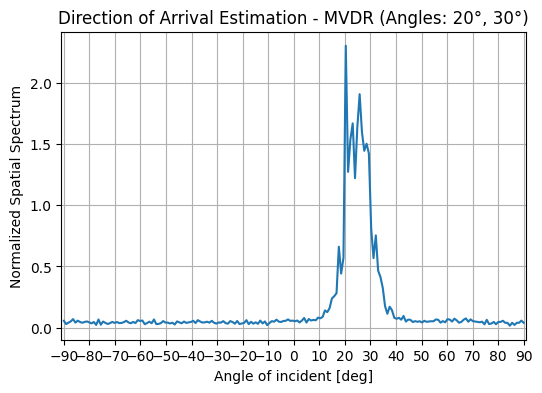

SNR = 10.0


In [3]:
N = 200  # Number of time samples
M = 8  # Number of array elements
P = [1, 1]  # Power of the two incoming signals
sig2 = P[0] / 10  # Variance of additive noise
angle_pairs = [(20, 30)]  # List of angle pairs for the two signals
observation_angles = np.linspace(-90, 90, 200)  # Observation angles (degrees)

# Call the function for multiple angle pairs
S_theta, G_theta, G_theta = MVDR_DOA(N, M, P, sig2, angle_pairs, observation_angles, savefig=False, w_fail=True)

SNR = 10*np.log10(P[0]/sig2)
print(f"SNR = {SNR}")

## 3)

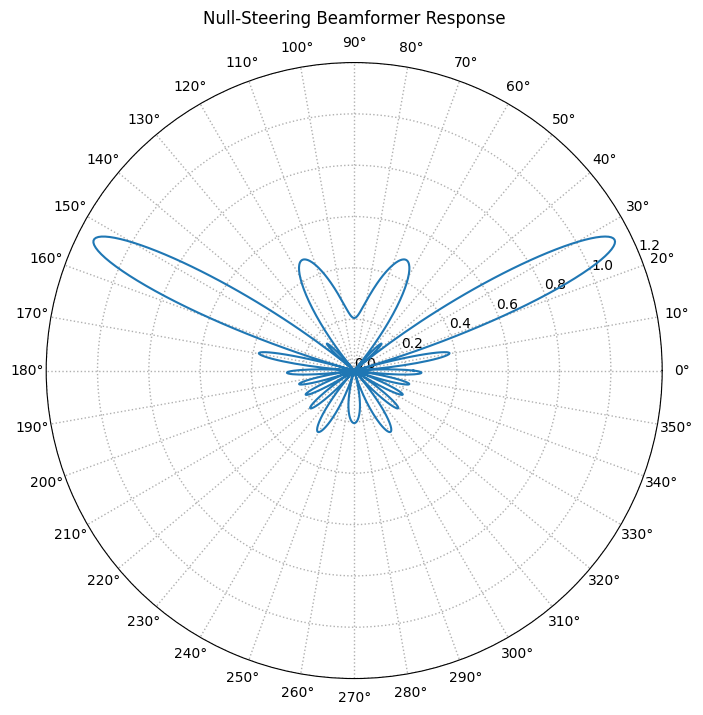

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def null_steering_beamformer(theta_desired, theta_nulls, M):
    """
    Compute the null-steering beamformer weights.
    
    Parameters:
    - theta_desired: float
        Desired direction of the signal (degrees).
    - theta_nulls: list of float
        List of null directions (degrees).
    - M: int
        Number of array elements.
    
    Returns:
    - w_ns: ndarray
        Null-steering beamformer weight vector.
    """
    # Convert angles to radians
    theta_desired_rad = np.deg2rad(theta_desired)
    theta_nulls_rad = np.deg2rad(theta_nulls)
    
    # Construct the steering matrix S
    S = np.zeros((M, len(theta_nulls) + 1), dtype=np.complex128)
    S[:, 0] = np.array([np.exp(1j * np.pi * np.sin(theta_desired_rad) * i) for i in range(M)])
    for j, theta in enumerate(theta_nulls_rad):
        S[:, j + 1] = np.array([np.exp(1j * np.pi * np.sin(theta) * i) for i in range(M)])
    
    # Construct the constraint vector e0
    e0 = np.zeros(len(theta_nulls) + 1, dtype=np.complex128)
    e0[0] = 1  # Gain constraint for the desired direction
    
    # Compute the null-steering weight vector using Eq. (18.42)
    w_ns = S @ np.linalg.pinv(S.conj().T @ S) @ e0
    return w_ns

def plot_null_steering_polar(theta_desired, theta_nulls, M, observation_angles):
    """
    Plot the null-steering beamformer response as a polar plot.
    
    Parameters:
    - theta_desired: float
        Desired direction of the signal (degrees).
    - theta_nulls: list of float
        List of null directions (degrees).
    - M: int
        Number of array elements.
    - observation_angles: ndarray
        Array of observation angles (degrees).
    """
    # Compute the beamformer weights
    w_ns = null_steering_beamformer(theta_desired, theta_nulls, M)
    
    # Compute the array response
    response = []
    for theta in observation_angles:
        steering_vector = np.array([np.exp(1j * np.pi * np.sin(np.deg2rad(theta)) * i) for i in range(M)])
        response.append(np.abs(np.dot(w_ns.conj().T, steering_vector)))
    
    # Normalize the response
    response = np.array(response)

    # Convert angles to radians for polar plotting
    observation_angles_rad = np.deg2rad(observation_angles)
    
    # Plot the polar beam pattern
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    ax.plot(observation_angles_rad, response)
    ax.set_title("Null-Steering Beamformer Response", va='bottom')
    ax.set_rticks(np.arange(0, 1.4, 0.2))  # Set radial ticks at 0.2 intervals
    # ax.set_rlabel_position(-22.5)  # Move the radial labels slightly
    ax.grid(True, linestyle=':', linewidth=1)
    # Customize angle ticks
    angle_ticks = np.arange(0,360,10) # Custom angles in degrees
    ax.set_thetagrids(angle_ticks)
    plt.show()

# Example Usage
theta_desired = 30  # Desired direction (degrees)
theta_nulls = [40, 50]  # Null directions (degrees)
M = 10  # Number of array elements
observation_angles = np.linspace(0, 360, 1000)  # Observation angles (degrees)

# Plot the null-steering response as a polar plot
plot_null_steering_polar(theta_desired, theta_nulls, M, observation_angles)


# Problem 2 - Matched Filter and Signal-to-Noise Ratio (SNR)

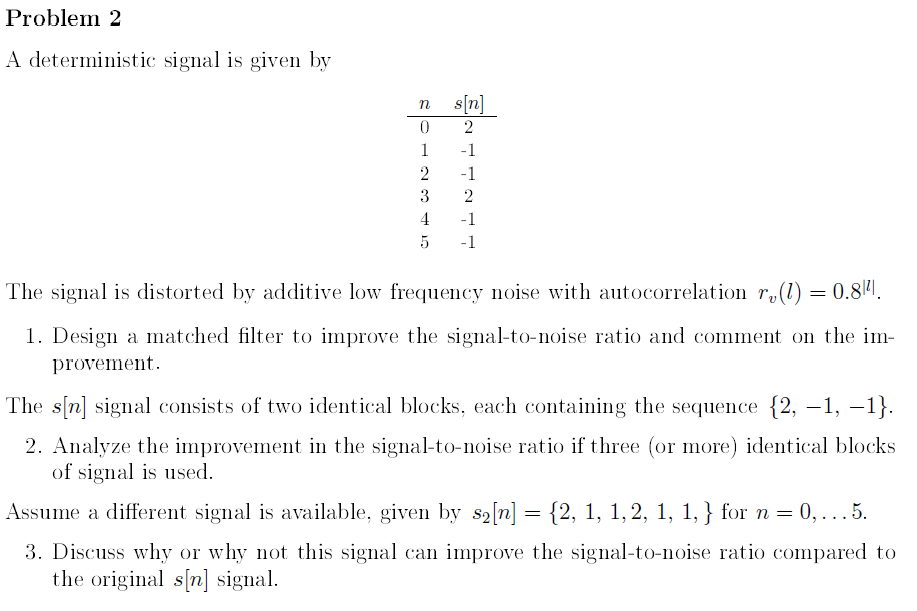

## 1)

In [5]:
import numpy as np

# Given signal s[n]
s = np.array([2, -1, -1, 2, -1, -1])
N = len(s)  # Length of the signal

# Noise autocorrelation parameters
rho = 0.8  # Correlation coefficient
sigma_v2 = 1  # Noise variance (r_v(0) = 1)

# Construct the noise autocorrelation matrix R_v
indices = np.arange(N)
R_v = rho ** np.abs(np.subtract.outer(indices, indices))

# Compute the inverse of R_v
R_v_inv = np.linalg.inv(R_v)

# Design the matched filter: h = R_v_inv * s
h = R_v_inv @ s

# Compute the input SNR
SNR_in = (s @ s) / (sigma_v2 * N)

# Compute the output SNR
numerator = (h @ s) ** 2
denominator = h @ R_v @ h
SNR_out = numerator / denominator

# Compute the SNR improvement
improvement_factor = SNR_out / SNR_in
improvement_dB = 10 * np.log10(improvement_factor)

# Print the results
print("Matched Filter Coefficients h[n]:")
for i, coeff in enumerate(h):
    print(f"h[{i}] = {coeff:.4f}")

print(f"\nInput SNR: {10*np.log10(SNR_in):.4f}")
print(f"Output SNR: {10*np.log10(SNR_out):.4f}")
print(f"SNR Improvement Factor: {improvement_factor:.4f}")
print(f"SNR Improvement in dB: {improvement_dB:.2f} dB")

Matched Filter Coefficients h[n]:
h[0] = 7.7778
h[1] = -6.7778
h[2] = -6.7778
h[3] = 13.5556
h[4] = -6.7778
h[5] = -0.5556

Input SNR: 3.0103
Output SNR: 18.0315
SNR Improvement Factor: 31.7778
SNR Improvement in dB: 15.02 dB


## 2)

In [6]:
import numpy as np

# Original sequence
s_single = np.array([2, -1, -1])

# Number of times to repeat the sequence
n_repeats = 5

# Create the longer sequence s[n]
s = np.tile(s_single, n_repeats)
N = len(s)  # Length of the signal
print(f"Signal with {n_repeats} identical blocks")
print(f"Signal = {s}")

# Noise autocorrelation parameters
rho = 0.8  # Correlation coefficient
sigma_v2 = 1  # Noise variance (r_v(0) = 1)

# Construct the noise autocorrelation matrix R_v
indices = np.arange(N)
R_v = rho ** np.abs(np.subtract.outer(indices, indices))

# Compute the inverse of R_v
R_v_inv = np.linalg.inv(R_v)

# Design the matched filter: h = R_v_inv * s
h = R_v_inv @ s

# Compute the input SNR
SNR_in = (s @ s) / (sigma_v2 * N)

# Compute the output SNR
numerator = (h @ s) ** 2
denominator = h @ R_v @ h
SNR_out = numerator / denominator

# Compute the SNR improvement
improvement_factor = SNR_out / SNR_in
improvement_dB = 10 * np.log10(improvement_factor)

# Print the results
print("Matched Filter Coefficients h[n]:")
for i, coeff in enumerate(h):
    print(f"h[{i}] = {coeff:.4f}")

print(f"\nInput SNR: {10*np.log10(SNR_in):.4f}")
print(f"Output SNR: {10*np.log10(SNR_out):.4f}")
print(f"SNR Improvement Factor: {improvement_factor:.4f}")
print(f"SNR Improvement in dB: {improvement_dB:.2f} dB")

Signal with 5 identical blocks
Signal = [ 2 -1 -1  2 -1 -1  2 -1 -1  2 -1 -1  2 -1 -1]
Matched Filter Coefficients h[n]:
h[0] = 7.7778
h[1] = -6.7778
h[2] = -6.7778
h[3] = 13.5556
h[4] = -6.7778
h[5] = -6.7778
h[6] = 13.5556
h[7] = -6.7778
h[8] = -6.7778
h[9] = 13.5556
h[10] = -6.7778
h[11] = -6.7778
h[12] = 13.5556
h[13] = -6.7778
h[14] = -0.5556

Input SNR: 3.0103
Output SNR: 22.6847
SNR Improvement Factor: 92.7778
SNR Improvement in dB: 19.67 dB


## 3)

In [10]:
import numpy as np

# Original sequence
s_single = np.array([2, 1, 1])

# Number of times to repeat the sequence
n_repeats = 2

# Create the longer sequence s[n]
s = np.tile(s_single, n_repeats)
N = len(s)  # Length of the signal
print(f"Signal with {n_repeats} identical blocks")
print(f"Signal = {s}")

# Noise autocorrelation parameters
rho = 0.8  # Correlation coefficient
sigma_v2 = 1  # Noise variance (r_v(0) = 1)

# Construct the noise autocorrelation matrix R_v
indices = np.arange(N)
R_v = rho ** np.abs(np.subtract.outer(indices, indices))

# Compute the inverse of R_v
R_v_inv = np.linalg.inv(R_v)

# Design the matched filter: h = R_v_inv * s
h = R_v_inv @ s

# Compute the input SNR
SNR_in = (s @ s) / (sigma_v2 * N)

# Compute the output SNR
numerator = (h @ s) ** 2
denominator = h @ R_v @ h
SNR_out = numerator / denominator

# Compute the SNR improvement
improvement_factor = SNR_out / SNR_in
improvement_dB = 10 * np.log10(improvement_factor)

# Print the results
print("Matched Filter Coefficients h[n]:")
for i, coeff in enumerate(h):
    print(f"h[{i}] = {coeff:.4f}")

print(f"\nInput SNR: {10*np.log10(SNR_in):.4f}")
print(f"Output SNR: {10*np.log10(SNR_out):.4f}")
print(f"SNR Improvement Factor: {improvement_factor:.4f}")
print(f"SNR Improvement in dB: {improvement_dB:.2f} dB")

Signal with 2 identical blocks
Signal = [2 1 1 2 1 1]
Matched Filter Coefficients h[n]:
h[0] = 3.3333
h[1] = -2.1111
h[2] = -2.1111
h[3] = 4.6667
h[4] = -2.1111
h[5] = 0.5556

Input SNR: 3.0103
Output SNR: 10.0955
SNR Improvement Factor: 5.1111
SNR Improvement in dB: 7.09 dB


# Problem 3 - Autocorrelation and Spectral Analysis

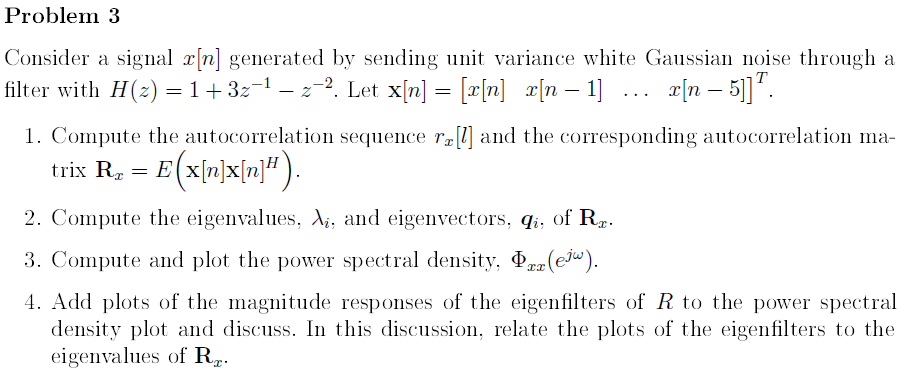

## 1)

The autocorrelation sequence of a given signal is defined by:
\begin{equation}
    r_x[l]=\sum_k h[k]h[k+l]
\end{equation}
The impulse response h[n] is given as the inverse of the filter transfer function $H(z)=1+z^{-1}-z^{-2}$
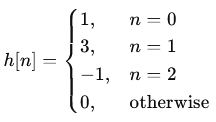

since h[n] is non-zero only for $n=0,1,2$, we compute $r_x[l]$ for $l$ from -2 to 2.
\begin{aligned}
    r_x[-2] &= h[2]h[0] = (-1)\cdot1=-1 \\
    r_x[-1] &= h[1]h[0]+h[2]h[1]=3\cdot1+(-1)\cdot3=0 \\
    r_x[0] &= h[0]h[0]+h[1]h[1]+h[2]h[2]=1^2+3^2+(-1)^2=11 \\
    r_x[1] &= h[0]h[1] + h[1]h[2] = 1\cdot3+3\cdot(-1)=0 \\
    r_x[2] &= h[0]h[2] = 1\cdot(-1)=-1
\end{aligned}

The autocorrelation matrix $\bold{R}_x$ is a Toeplitz matrix where each element $\bold{R}_x[i,j]$ is defined by $\bold{R}_x[i,j]=r_x[i-j]$. For $x[n]=[x[n],x[n-1],\dots,x[n-5]]^T$, we have with the computed values:

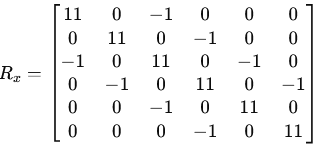

In [44]:
import numpy as np

# Define the impulse response h[n] based on the filter H(z)
h = np.array([1, 3, -1])

# Compute the autocorrelation sequence r_x[l]
# The autocorrelation of h[n] is computed using numpy.correlate
r_x = np.correlate(h, h, mode='full')

# The lags for r_x[l] range from -(len(h)-1) to +(len(h)-1)
lags = np.arange(-len(h)+1, len(h))

# Display the autocorrelation sequence
print("Autocorrelation sequence r_x[l]:")
for lag, value in zip(lags, r_x):
    print(f"r_x[{lag}] = {value}")

# Define the size of the autocorrelation matrix R_x
N = 6  # Since x[n] = [x[n], x[n-1], ..., x[n-5]]^T
R_x = np.zeros((N, N))

# Fill the autocorrelation matrix R_x
for i in range(N):
    for j in range(N):
        lag = i - j
        index = lag + (len(h) - 1)
        if 0 <= index < len(r_x):
            R_x[i, j] = r_x[index]
        else:
            R_x[i, j] = 0

# Display the autocorrelation matrix
print("\nAutocorrelation matrix R_x:")
print(R_x)

Autocorrelation sequence r_x[l]:
r_x[-2] = -1
r_x[-1] = 0
r_x[0] = 11
r_x[1] = 0
r_x[2] = -1

Autocorrelation matrix R_x:
[[11.  0. -1.  0.  0.  0.]
 [ 0. 11.  0. -1.  0.  0.]
 [-1.  0. 11.  0. -1.  0.]
 [ 0. -1.  0. 11.  0. -1.]
 [ 0.  0. -1.  0. 11.  0.]
 [ 0.  0.  0. -1.  0. 11.]]


## 2)

The eigenvalues, $\lambda_i$, and eigenvectores, $q_i$, are computed by solving the characterstic equation:

\begin{equation}
    \text{DET}(\bold{R}_x-\lambda I)=0
\end{equation}
This is computed via python's numpy.linalg.eigh function. 

In [45]:
# Compute the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(R_x)

# Display the eigenvalues
print("Eigenvalues (λ_i):")
for i, eigenvalue in enumerate(eigenvalues, start=1):
    print(f"λ_{i} = {eigenvalue:.4f}")

# Display the eigenvectors
print("\nEigenvectors (q_i):")
for i in range(eigenvectors.shape[1]):
    print(f"q_{i+1} = {eigenvectors[:, i]}")
    
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]


Eigenvalues (λ_i):
λ_1 = 9.5858
λ_2 = 9.5858
λ_3 = 11.0000
λ_4 = 11.0000
λ_5 = 12.4142
λ_6 = 12.4142

Eigenvectors (q_i):
q_1 = [-0.5         0.         -0.70710678  0.         -0.5         0.        ]
q_2 = [ 0.         -0.5         0.         -0.70710678  0.         -0.5       ]
q_3 = [ 0.         -0.70710678  0.          0.          0.          0.70710678]
q_4 = [-7.07106781e-01  0.00000000e+00 -5.55111512e-16  0.00000000e+00
  7.07106781e-01  0.00000000e+00]
q_5 = [ 0.5         0.         -0.70710678  0.          0.5         0.        ]
q_6 = [ 0.         -0.5         0.          0.70710678  0.         -0.5       ]


## 3)

The input to the filter is white Gaussian noise $w[n]$ with unit variance, whose PSD is:
\begin{equation}
    \Phi_{ww}(e^{j\omega})=\sigma_w^2=1
\end{equation}
For a LTI system, the output PDS $\Phi_{xx}(e^{j\omega})$ is related to the inpus PSP and the frequency response
\begin{equation}
    \Phi_{xx}(e^{j\omega})=|H(e^{j\omega})|^2\Phi_{ww}(e^{j\omega})
\end{equation}
Since $\Phi_{ww}(e^{j\omega})=1$, we have 
\begin{equation}
    \Phi_{xx}(e^{j\omega})=|H(e^{j\omega})|^2
\end{equation}
We have to go from z-domain by substituting $z=e^{j\omega}$. 
\begin{equation}
    H(e^{j\omega})=1+3e^{-j\omega}-e^{-2j\omega}
\end{equation}
Computing the sqaured magnitude, we get
\begin{equation}
    |H(e^{j\omega})|^2 = H(e^{j\omega})H^\ast(e^{j\omega})=(1+3e^{-j\omega}-e^{-2j\omega})(1+3e^{j\omega}-e^{2j\omega})
\end{equation}
After some computing and simplification, we arrive at
\begin{equation}
    |H(e^{j\omega})|^2 = 11-2\cos(2\omega)
\end{equation}

Additionally, the PSD can be found via the Fourier transform of the autocorrelation function $r_x[l]$:
\begin{equation}
    \Phi_{xx}(e^{j\omega})=\sum_{-\infty}^\infty r_x[l]e^{-j\omega l}
\end{equation}
This is all plotted in python

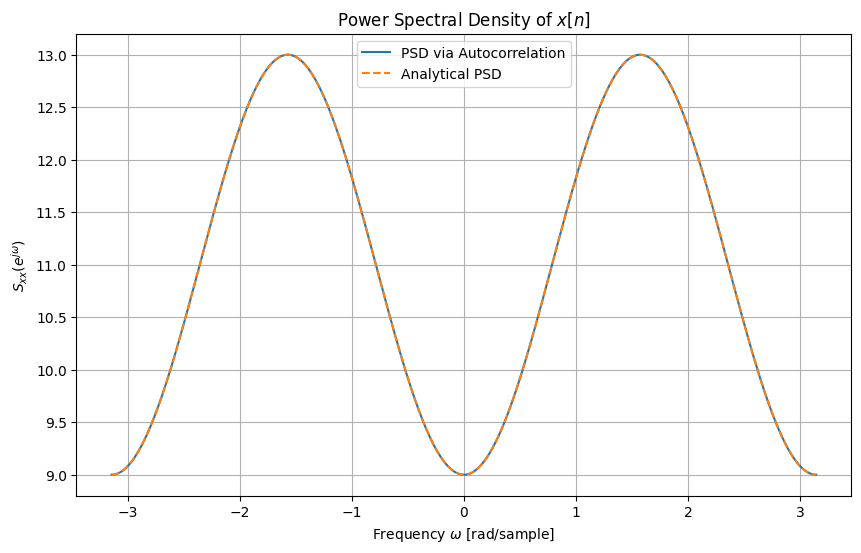

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Define the frequency range
omega = np.linspace(-np.pi, np.pi, 1000)

# Initialize S_xx(e^{j\omega}) to zero, with complex data type
S_xx = np.zeros_like(omega, dtype=complex)

# Compute S_xx(e^{j\omega}) using the Fourier Transform of r_x[l]
for lag, r in zip(lags, r_x):
    S_xx += r * np.exp(-1j * omega * lag)
S_xx = np.real(S_xx)

# Optional: Compute the PSD using the analytical expression for comparison
S_xx_analytical = 11 - 2 * np.cos(2 * omega)

# Step 5: Plot the PSD
plt.figure(figsize=(10, 6))
plt.plot(omega, S_xx, label='PSD via Autocorrelation')
plt.plot(omega, S_xx_analytical, '--', label='Analytical PSD')
plt.title('Power Spectral Density of $x[n]$')
plt.xlabel(r'Frequency $\omega$ [rad/sample]')
plt.ylabel(r'$S_{xx}(e^{j\omega})$')
plt.grid(True)
plt.legend()
plt.show()

## 4)

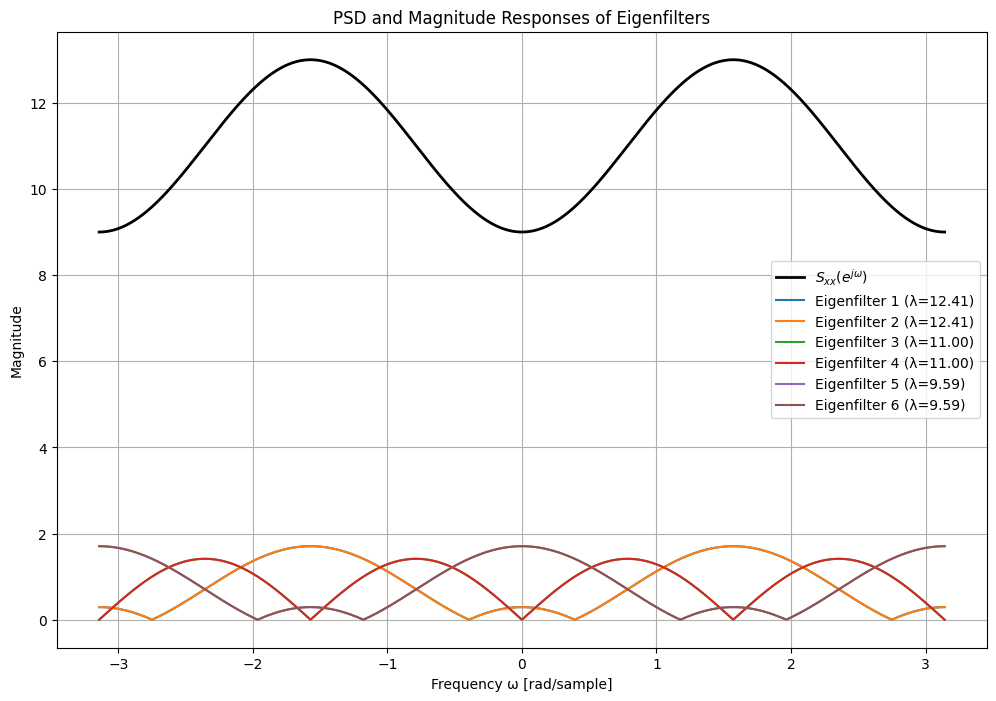

In [43]:
# Define the frequency range
omega = np.linspace(-np.pi, np.pi, 1000)

# Initialize a list to store the magnitude responses
H_magnitude = []

# Compute the frequency response for each eigenfilter
for i in range(eigenvectors.shape[1]):
    q_i = eigenvectors[:, i]
    # Compute the frequency response H_i(e^{jω})
    H_i = np.zeros_like(omega, dtype=complex)
    for n in range(len(q_i)):
        H_i += q_i[n] * np.exp(-1j * omega * n)
    # Compute the magnitude response |H_i(e^{jω})|
    H_mag = np.abs(H_i)
    H_magnitude.append(H_mag)

# Plot the PSD
plt.figure(figsize=(12, 8))
plt.plot(omega, S_xx, label=r'$S_{xx}(e^{j\omega})$', color='black', linewidth=2)

# Plot the magnitude responses of the eigenfilters
for i, H_mag in enumerate(H_magnitude):
    plt.plot(omega, H_mag, label=f'Eigenfilter {i+1} (λ={eigenvalues[i]:.2f})')

# Configure the plot
plt.title('PSD and Magnitude Responses of Eigenfilters')
plt.xlabel('Frequency ω [rad/sample]')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.show()